## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

C:\Users\10709151\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.5, 0.8]
redice_lr_patient = [5, 10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 2s 37us/step - loss: 1.3694 - acc: 0.5212 - val_loss: 1.5494 - val_acc: 0.4596
Epoch 14/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3471 - acc: 0.5307 - val_loss: 1.5422 - val_acc: 0.4584
Epoch 15/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.3289 - acc: 0.5366 - val_loss: 1.5433 - val_acc: 0.4576
Epoch 16/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3117 - acc: 0.5452 - val_loss: 1.5285 - val_acc: 0.4650
Epoch 17/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2933 - acc: 0.5497 - val_loss: 1.5285 - val_acc: 0.4644
Epoch 18/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2769 - acc: 0.5565 - val_loss: 1.5235 - val_acc: 0.4664
Epoch 19/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.2602 - acc: 0.5632 - val_loss: 1.5100 - val_acc: 0.4711
Epoch 20/25
50000/50000 [=====================

50000/50000 [==============================] - 3s 54us/step - loss: 2.3562 - acc: 0.2273 - val_loss: 2.2582 - val_acc: 0.2830
Epoch 2/25
50000/50000 [==============================] - 2s 36us/step - loss: 1.8657 - acc: 0.3517 - val_loss: 1.9419 - val_acc: 0.3437
Epoch 3/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.7295 - acc: 0.3926 - val_loss: 1.8058 - val_acc: 0.3726
Epoch 4/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.6517 - acc: 0.4189 - val_loss: 1.7274 - val_acc: 0.4012
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5968 - acc: 0.4387 - val_loss: 1.6996 - val_acc: 0.4096
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5518 - acc: 0.4554 - val_loss: 1.6618 - val_acc: 0.4227
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5148 - acc: 0.4665 - val_loss: 1.6383 - val_acc: 0.4271
Epoch 8/25
50000/50000 [============================

50000/50000 [==============================] - 2s 37us/step - loss: 0.4863 - acc: 0.8504 - val_loss: 1.5834 - val_acc: 0.5058

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 24/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.4310 - acc: 0.8774 - val_loss: 1.5612 - val_acc: 0.5140
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 0.4099 - acc: 0.8864 - val_loss: 1.5395 - val_acc: 0.5234
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_16 (Batc (None, 512)               2048   

50000/50000 [==============================] - 2s 38us/step - loss: 1.1322 - acc: 0.6109 - val_loss: 1.4806 - val_acc: 0.4840
Epoch 10/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0995 - acc: 0.6245 - val_loss: 1.5129 - val_acc: 0.4690
Epoch 11/25
50000/50000 [==============================] - 2s 38us/step - loss: 1.0699 - acc: 0.6346 - val_loss: 1.4460 - val_acc: 0.4908
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0406 - acc: 0.6470 - val_loss: 1.4548 - val_acc: 0.4888
Epoch 13/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0120 - acc: 0.6573 - val_loss: 1.4647 - val_acc: 0.4912
Epoch 14/25
50000/50000 [==============================] - 2s 38us/step - loss: 0.9868 - acc: 0.6691 - val_loss: 1.4268 - val_acc: 0.5018
Epoch 15/25
50000/50000 [==============================] - 2s 39us/step - loss: 0.9627 - acc: 0.6775 - val_loss: 1.4469 - val_acc: 0.4981
Epoch 16/25
50000/50000 [=====================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.8048 - acc: 0.3762 - val_loss: 2.4565 - val_acc: 0.2664
Epoch 2/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.5344 - acc: 0.4578 - val_loss: 2.0687 - val_acc: 0.3236
Epoch 3/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.4265 - acc: 0.4952 - val_loss: 2.1444 - val_acc: 0.3312
Epoch 4/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.3524 - acc: 0.5214 - val_loss: 1.9259 - val_acc: 0.3455
Epoch 5/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2889 - acc: 0.5456 - val_loss: 2.6837 - val_acc: 0.2547
Epoch 6/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2424 - acc: 0.5600 - val_loss: 2.0941 - val_acc: 0.2955
Epoch 7/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2066 - acc: 0.5724 - val_loss: 1.9406 - val_acc

50000/50000 [==============================] - 2s 37us/step - loss: 0.6389 - acc: 0.7999 - val_loss: 1.5036 - val_acc: 0.4987
Epoch 23/25
50000/50000 [==============================] - 2s 37us/step - loss: 0.6163 - acc: 0.8103 - val_loss: 1.5974 - val_acc: 0.4767
Epoch 24/25
50000/50000 [==============================] - 2s 37us/step - loss: 0.5962 - acc: 0.8177 - val_loss: 1.5835 - val_acc: 0.4901
Epoch 25/25
50000/50000 [==============================] - 2s 37us/step - loss: 0.5729 - acc: 0.8264 - val_loss: 1.5772 - val_acc: 0.4847
Numbers of exp: 10, reduce_factor: 0.80, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch

50000/50000 [==============================] - 2s 36us/step - loss: 1.2523 - acc: 0.5693 - val_loss: 1.5527 - val_acc: 0.4561
Epoch 9/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.2161 - acc: 0.5807 - val_loss: 1.5646 - val_acc: 0.4462
Epoch 10/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1803 - acc: 0.5956 - val_loss: 1.5892 - val_acc: 0.4501
Epoch 11/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1489 - acc: 0.6069 - val_loss: 1.4920 - val_acc: 0.4775
Epoch 12/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.1187 - acc: 0.6187 - val_loss: 1.5141 - val_acc: 0.4723
Epoch 13/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0882 - acc: 0.6312 - val_loss: 1.5034 - val_acc: 0.4759
Epoch 14/25
50000/50000 [==============================] - 2s 37us/step - loss: 1.0588 - acc: 0.6410 - val_loss: 1.4901 - val_acc: 0.4835
Epoch 15/25
50000/50000 [======================

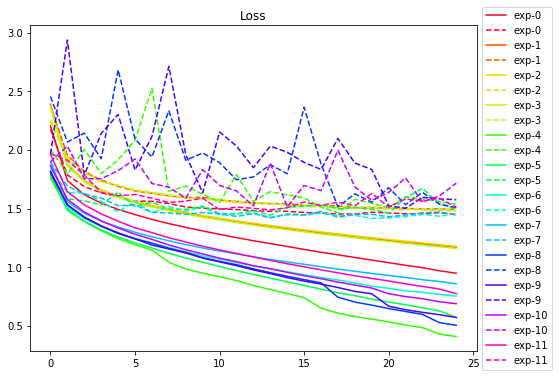

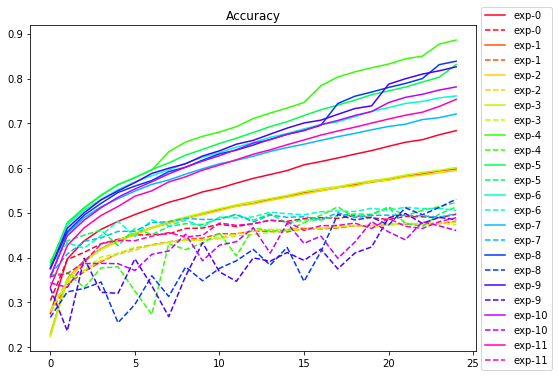

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()